# Polymer Chemistry Informed Neural Networks (PCINNs)

**Paper:** Ballard, N. *Polymer Chemistry Informed Neural Networks.* *Polym. Chem.*, 2024. DOI: [10.1039/D4PY00995A](https://doi.org/10.1039/D4PY00995A)

**GitHub:** [PolymatGIQ/PCINN](https://github.com/PolymatGIQ/PCINN)

This notebook implements the PCINN method for predicting methyl methacrylate (MMA) free-radical polymerization outcomes. The approach combines a data-driven neural network with Jacobian-based regularization from a pretrained kinetic ("theory") model. The theory model provides gradient information that guides the trainable network toward physically consistent predictions, yielding improved generalization compared to a purely data-driven baseline.

In [1]:
# Install pinned dependencies (verified compatible as of February 2026).
# On systems with CUDA, follow https://pytorch.org/get-started/locally/
# to install the CUDA-enabled PyTorch build instead of the default CPU-only wheel.
# If a pin fails to resolve, check PyPI for the latest patch in the same minor
# series (e.g., numpy==2.4.3 if 2.4.2 is superseded).
%pip install torch==2.10.0 numpy==2.4.2 pandas==2.2.3 matplotlib==3.10.8 openpyxl==3.1.5 "ipykernel>=6.29,<7"

Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.
You can safely remove it manually.


In [2]:
%matplotlib inline

from __future__ import annotations

import os

# UNSAFE WORKAROUND — only enable if you hit OpenMP duplication errors.
# Can crash or silently produce incorrect results. Must be set before
# NumPy/PyTorch (and other heavy numeric libs) are imported in a fresh kernel.
ENABLE_UNSAFE_KMP_WORKAROUND = False

if ENABLE_UNSAFE_KMP_WORKAROUND:
    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import copy
import json
import pickle
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.func import jacrev, vmap


## Reproducibility & Device

Seed all RNGs for reproducible results across runs. GPU is used when available.

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Optional strictness (may slow things down / error on nondeterministic ops):
# torch.use_deterministic_algorithms(True)
# torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Model Definitions

Two neural network architectures are used. **`NNmodel`** is the trainable predictive network (5 inputs → 128 → 64 → 6 outputs, tanh activations) used for both the baseline and PCINN experiments. **`DomainModel`** is the pretrained theory surrogate (5 → 128 → 128 → 64 with split output heads: sigmoid for conversion, softplus for molecular weights) that provides Jacobian targets during PCINN training. See paper Scheme 2 (theory model) and Scheme 3 (PCINN architecture).

In [4]:
class NNmodel(nn.Module):
    """Data-driven predictive network for MMA polymerization.

    Architecture: 5 → 128 → 64 → 6 (tanh activations).

    Inputs:  (batch, 5) — [M], [S], [I], temp, time  (all scaled 0–1)
    Outputs: (batch, 6) — X (conversion), log10(Mn), log10(Mw),
             log10(Mz), log10(Mz+1), log10(Mv)
    """

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class DomainModel(nn.Module):
    """Pretrained kinetic theory surrogate ("domain model").

    Architecture: 5 → 128 → 128 → 64 with split output heads.

    Inputs:  (batch, 5) — same as NNmodel
    Outputs: (batch, 6) — X via sigmoid ∈ [0, 1],
             Mn/Mw/Mz/Mz+1/Mv via softplus > 0  (physical units)
    """

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.Xout = nn.Linear(64, 1)
        self.Mout = nn.Linear(64, 5)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        X_out = torch.sigmoid(self.Xout(x))      # conversion
        M_out = torch.nn.functional.softplus(self.Mout(x))  # Mn, Mw, Mz, Mz+1, Mv

        return torch.cat((X_out, M_out), dim=-1)

## Data Preprocessing

Input features are scaled to the [0, 1] range using precomputed per-feature min and max values stored in `scalerx_min.npy` and `scalerx_max.npy`. The five molecular weight outputs (Mn, Mw, Mz, Mz+1, Mv) are log10-transformed before training to reduce scale differences, while conversion (X) is left on its original scale.

In [5]:
def scalefeaturezeroone(
    x: np.ndarray,
    scalerxmax: np.ndarray,
    scalerxmin: np.ndarray,
    *,
    eps: float = 1e-12,
) -> np.ndarray:
    """Min-max scale features to [0, 1] with numerical safety."""
    denom = np.maximum(scalerxmax - scalerxmin, eps)
    return (x - scalerxmin) / denom

In [6]:
scalerx_max_np = np.load('scalerx_max.npy')
scalerx_min_np = np.load('scalerx_min.npy')

# Torch versions for use inside training loops (avoids NumPy/Torch interop warnings)
SCALERX_MAX = torch.from_numpy(scalerx_max_np).float().to(DEVICE)
SCALERX_MIN = torch.from_numpy(scalerx_min_np).float().to(DEVICE)
SCALERX_DENOM = torch.clamp(SCALERX_MAX - SCALERX_MIN, min=1e-12)

# Load training data
df = pd.read_excel('PMMAordered.xlsx')

dfX = df[["[M]", "[S]", "[I]", "temp", "time", "Reaction"]]
dfY = df[["X", "Mn", "Mw", "Mz", "Mzplus1", "Mv"]]

Xdata = dfX.values
Ydata = dfY.values

Ydata[:, 1:] = np.log10(Ydata[:, 1:])
Xdata[:, :5] = scalefeaturezeroone(Xdata[:, :5], scalerx_max_np, scalerx_min_np)

dfGPC = df.iloc[:, 18:]
GPCdata = dfGPC.values

# Load and freeze pretrained theory model
Domain_NN = DomainModel().to(DEVICE)

try:
    Domain_NN.load_state_dict(
        torch.load('MMA_solution_net.pt', weights_only=True, map_location=DEVICE)
    )
except pickle.UnpicklingError:
    Domain_NN.load_state_dict(
        torch.load('MMA_solution_net.pt', weights_only=False, map_location=DEVICE)
    )

Domain_NN.eval()
for p in Domain_NN.parameters():
    p.requires_grad_(False)

print(f"Domain_NN on {next(Domain_NN.parameters()).device}, eval={not Domain_NN.training}")
print(f"SCALERX_DENOM min={SCALERX_DENOM.min().item():.2e}")

Domain_NN on cpu, eval=True
SCALERX_DENOM min=9.50e-02


## Jacobian Sampling Configuration

During PCINN training, 32 random points are sampled per epoch from the physical domain to compute Jacobian matching loss. The sampling ranges correspond to experimentally relevant conditions: temperature 323–363 K (50–90 °C), monomer concentration [M] 0.5–5 mol/L, initiator concentration [I] 0.005–0.1 mol/L, and reaction time 300–36,000 s (5 min to 10 hours). See paper eqn (9) for the combined loss function.

In [7]:
Tupper = 273 + 90
Tlower = 273 + 50

Mupper = 5
Mlower = 0.5

Iupper = 0.1
Ilower = 0.005

timeupper = 10 * 60 * 60
timelower = 5 * 60

M_sampler = torch.distributions.Uniform(low=Mlower, high=Mupper)
T_sampler = torch.distributions.Uniform(low=Tlower, high=Tupper)
I_sampler = torch.distributions.Uniform(low=Ilower, high=Iupper)
time_sampler = torch.distributions.Uniform(low=timelower, high=timeupper)

## Training Configuration

A leave-one-experiment-out cross-validation strategy is used: the dataset contains 8 distinct polymerization reactions, and `TestReaction` selects which reaction is held out for testing while the remaining 7 are used for training. To reproduce the full cross-validation results from paper Table 3, run this notebook 8 times with `TestReaction` set to each value from 1 to 8.

In [8]:
TestReaction = 8  # Integer between 1 and 8. Picks reaction that will be tested on (other reactions for training)

# Convert train/test splits to tensors on DEVICE once (no repeated torch.from_numpy in loops)
Xtrainsample = torch.from_numpy(Xdata[Xdata[:, 5] != TestReaction, :5]).float().to(DEVICE)
Ytrainsample = torch.from_numpy(Ydata[Xdata[:, 5] != TestReaction]).float().to(DEVICE)

Xtestsample = torch.from_numpy(Xdata[Xdata[:, 5] == TestReaction, :5]).float().to(DEVICE)
Ytestsample = torch.from_numpy(Ydata[Xdata[:, 5] == TestReaction]).float().to(DEVICE)

print(f"Train: {Xtrainsample.shape}, Test: {Xtestsample.shape}, device={Xtrainsample.device}")

Train: torch.Size([49, 5]), Test: torch.Size([8, 5]), device=cpu


In [9]:
def safe_log(x: list[float], eps: float = 1e-12) -> np.ndarray:
    """Numerically safe natural log for loss curves (clamps near-zero values)."""
    arr = np.asarray(x, dtype=np.float64)
    return np.log(np.clip(arr, eps, None))

## Baseline Neural Network Training

This cell trains a conventional data-only neural network (no Jacobian regularization) as a control comparison. The model is trained for 10,000 epochs with Adam (lr=3e-4) and MSE loss on the training data only. This serves as the baseline against which the PCINN is compared in paper Table 3.

In [10]:
# [ORIGINAL — paper baseline, do not execute]
# Kept for reproducibility comparison. Use the improved cell below instead.

# model = NNmodel()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=3E-4)
#
# epochs = 10000
# reg_losses = []
# reg_losses_test = []
# for epoch in range(epochs):
#     Sum_Obj_loss = 0
#     pred = model(Xtrainsample)
#     trainloss = loss_function(pred, Ytrainsample)
#     Sum_Obj_loss += trainloss
#     if epoch >= 1:
#         trainloss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     pred = model(Xtestsample)
#     testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
#     reg_losses.append(float(Sum_Obj_loss))
#     reg_losses_test.append(float(testloss))
#
# NNpred = model(Xtestsample)
#
# plt.plot(np.log(reg_losses), label='Training loss')
# plt.plot(np.log(reg_losses_test), label='Test loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

[Baseline] epoch=500/10000 train=0.128939 test=0.0339902


[Baseline] epoch=1000/10000 train=0.0151143 test=0.152319


[Baseline] epoch=1500/10000 train=0.00639641 test=0.162204


[Baseline] epoch=2000/10000 train=0.00427281 test=0.145994


[Baseline] epoch=2500/10000 train=0.00365353 test=0.138222


[Baseline] epoch=3000/10000 train=0.00325729 test=0.133477


[Baseline] epoch=3500/10000 train=0.00299282 test=0.12977


[Baseline] epoch=4000/10000 train=0.00272791 test=0.126875


[Baseline] epoch=4500/10000 train=0.00233491 test=0.124275


[Baseline] epoch=5000/10000 train=0.00193902 test=0.119328


[Baseline] epoch=5500/10000 train=0.00163401 test=0.111939


[Baseline] epoch=6000/10000 train=0.00144572 test=0.106284


[Baseline] epoch=6500/10000 train=0.00133776 test=0.105172


[Baseline] epoch=7000/10000 train=0.00124326 test=0.107492


[Baseline] epoch=7500/10000 train=0.00110907 test=0.111994


[Baseline] epoch=8000/10000 train=0.000943026 test=0.114756


[Baseline] epoch=8500/10000 train=0.000820066 test=0.118077


[Baseline] epoch=9000/10000 train=0.000741055 test=0.122204


[Baseline] epoch=9500/10000 train=0.000675911 test=0.125671


[Baseline] epoch=10000/10000 train=0.000610114 test=0.129292


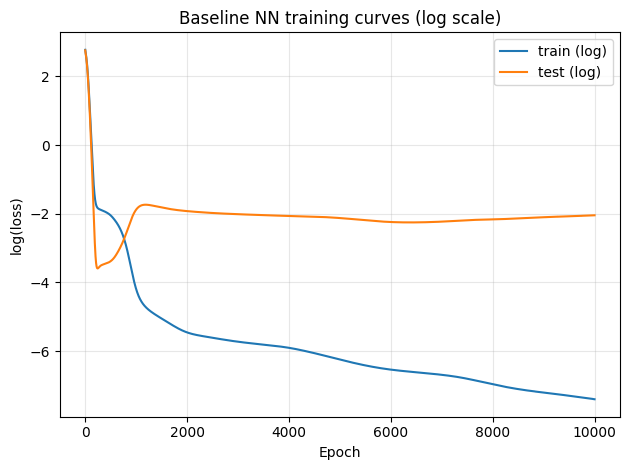

In [11]:
model = NNmodel().to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

EPOCHS = 10_000
train_losses: list[float] = []
test_losses: list[float] = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad(set_to_none=True)

    pred = model(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)
    trainloss.backward()
    optimizer.step()

    train_losses.append(trainloss.item())

    model.eval()
    with torch.inference_mode():
        test_pred = model(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(f"[Baseline] epoch={epoch+1}/{EPOCHS} train={train_losses[-1]:.6g} test={test_losses[-1]:.6g}")

NNpred = model(Xtestsample)

plt.figure()
plt.plot(safe_log(train_losses), label="train (log)")
plt.plot(safe_log(test_losses), label="test (log)")
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.title("Baseline NN training curves (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## PCINN Training

The PCINN augments the standard data-driven MSE loss with a Jacobian matching term (see paper eqn 9). At each epoch, 32 random points are sampled from the physical domain and the Jacobian of both the trainable network and the pretrained theory network are computed using `vmap(jacrev(...))`. The MSE between these Jacobians is added to the data loss, encouraging the PCINN to learn input-output sensitivities consistent with the underlying kinetic model.

In [12]:
# [ORIGINAL — paper baseline, do not execute]
# Kept for reproducibility comparison. Use the improved cell below instead.

# PCINNmodel = NNmodel()
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(PCINNmodel.parameters(), lr=3E-4)
#
# epochs = 10000
# reg_losses = []
# reg_losses_test = []
# totaljacsamples = 32
#
# for epoch in range(epochs):
#     Sum_Jac_loss = 0
#     Sum_Obj_loss = 0
#
#     pred = PCINNmodel(Xtrainsample)
#     trainloss = loss_function(pred, Ytrainsample)
#     Sum_Obj_loss += trainloss
#
#     Msample = M_sampler.sample((32, 1))
#     Ssample = 10 - Msample
#     Isample = I_sampler.sample((32, 1))
#     Tsample = T_sampler.sample((32, 1))
#     tsample = time_sampler.sample((32, 1))
#     sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), 1)
#     sampl = (sampl - scalerx_min) / (scalerx_max - scalerx_min)
#
#     jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl.float())
#     jac_sampl = vmap(jacrev(PCINNmodel))(sampl.float())
#
#     jacloss = loss_function(jac_sampl, jac_theory_sampl)
#     Sum_Jac_loss += jacloss
#
#     loss = trainloss + jacloss
#
#     if epoch >= 1:
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     reg_losses.append(float(Sum_Obj_loss))
#     pred = PCINNmodel(Xtestsample)
#     testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
#     reg_losses_test.append(float(testloss))
#
# EBNNpred = PCINNmodel(Xtestsample)
#
# plt.plot(np.log(reg_losses), label='Training loss')
# plt.plot(np.log(reg_losses_test), label='Test loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

[PCINN] epoch=500/10000 obj=0.0134359 jac=0.170443 test=0.0110015


[PCINN] epoch=1000/10000 obj=0.00705738 jac=0.268849 test=0.00518006


[PCINN] epoch=1500/10000 obj=0.00515545 jac=0.128008 test=0.00403267


[PCINN] epoch=2000/10000 obj=0.00448638 jac=0.106943 test=0.00481005


[PCINN] epoch=2500/10000 obj=0.00412373 jac=0.0659516 test=0.00371781


[PCINN] epoch=3000/10000 obj=0.00399458 jac=0.0256813 test=0.0040058


[PCINN] epoch=3500/10000 obj=0.00371204 jac=0.0324886 test=0.0041484


[PCINN] epoch=4000/10000 obj=0.00369781 jac=0.0197388 test=0.00421294


[PCINN] epoch=4500/10000 obj=0.00366691 jac=0.0660086 test=0.00386596


[PCINN] epoch=5000/10000 obj=0.00375705 jac=0.061766 test=0.0045834


[PCINN] epoch=5500/10000 obj=0.00376378 jac=0.028492 test=0.00416363


[PCINN] epoch=6000/10000 obj=0.00356935 jac=0.0196464 test=0.00467277


[PCINN] epoch=6500/10000 obj=0.00342411 jac=0.0233459 test=0.00438553


[PCINN] epoch=7000/10000 obj=0.00344349 jac=0.0368499 test=0.00461301


[PCINN] epoch=7500/10000 obj=0.00340673 jac=0.0131841 test=0.0043961


[PCINN] epoch=8000/10000 obj=0.00340683 jac=0.0224974 test=0.00425243


[PCINN] epoch=8500/10000 obj=0.00327934 jac=0.017235 test=0.00306886


[PCINN] epoch=9000/10000 obj=0.00331734 jac=0.019454 test=0.00366711


[PCINN] epoch=9500/10000 obj=0.00325596 jac=0.0221215 test=0.00471673


[PCINN] epoch=10000/10000 obj=0.00329148 jac=0.162784 test=0.00403127


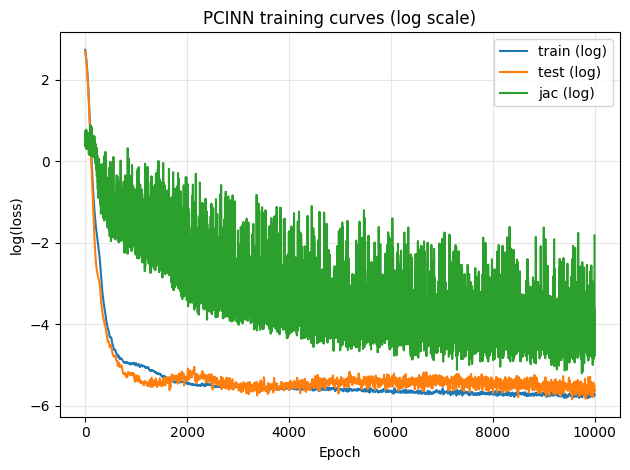

In [13]:
PCINNmodel = NNmodel().to(DEVICE)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(PCINNmodel.parameters(), lr=3e-4)

EPOCHS = 10_000
TOTAL_JAC_SAMPLES = 32

pcinn_train_losses: list[float] = []
pcinn_test_losses: list[float] = []
jac_losses: list[float] = []

for epoch in range(EPOCHS):
    PCINNmodel.train()
    optimizer.zero_grad(set_to_none=True)

    pred = PCINNmodel(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)

    # --- Jacobian sampling ---
    Msample = M_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Ssample = 10 - Msample
    Isample = I_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Tsample = T_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    tsample = time_sampler.sample((TOTAL_JAC_SAMPLES, 1))

    sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), dim=1).to(DEVICE)
    sampl = (sampl - SCALERX_MIN) / SCALERX_DENOM

    # Ensure sampl is a leaf tensor that can be differentiated
    sampl = sampl.float().detach().requires_grad_(True)

    # Theory Jacobian: grad enabled (needed for jacrev) but params frozen; detach as target
    jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl).detach()
    # PCINN Jacobian: requires grad so jacloss backprops into PCINN params
    jac_sampl = vmap(jacrev(PCINNmodel))(sampl)

    jacloss = loss_function(jac_sampl, jac_theory_sampl)

    loss = trainloss + jacloss
    loss.backward()
    optimizer.step()

    pcinn_train_losses.append(trainloss.item())
    jac_losses.append(jacloss.item())

    PCINNmodel.eval()
    with torch.inference_mode():
        test_pred = PCINNmodel(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    pcinn_test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(
            f"[PCINN] epoch={epoch+1}/{EPOCHS} "
            f"obj={pcinn_train_losses[-1]:.6g} jac={jac_losses[-1]:.6g} test={pcinn_test_losses[-1]:.6g}"
        )

EBNNpred = PCINNmodel(Xtestsample)

plt.figure()
plt.plot(safe_log(pcinn_train_losses), label="train (log)")
plt.plot(safe_log(pcinn_test_losses), label="test (log)")
plt.plot(safe_log(jac_losses), label="jac (log)")
plt.xlabel("Epoch")
plt.ylabel("log(loss)")
plt.title("PCINN training curves (log scale)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Model Export

Save the trained PCINN weights, an inference bundle (weights + scaling parameters + metadata), and a human-readable JSON metadata file. A smoke-test reload verifies the saved weights produce identical predictions.

In [14]:
EXPORT_DIR = Path("exports")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

fold = int(TestReaction)

weights_path = EXPORT_DIR / f"pcinn_fold{fold}_weights.pt"
bundle_path = EXPORT_DIR / f"pcinn_fold{fold}_bundle.pt"
meta_path = EXPORT_DIR / f"pcinn_fold{fold}_meta.json"

PCINNmodel.eval()

# 1) Weights only
torch.save(PCINNmodel.state_dict(), weights_path)

# 2) Full inference bundle
bundle = {
    "model_class": "NNmodel",
    "model_state_dict": copy.deepcopy(PCINNmodel.state_dict()),
    "scalerx_min": scalerx_min_np,
    "scalerx_max": scalerx_max_np,
    "y_log10_applied_to_columns_1_to_end": True,
    "fold": fold,
    "pytorch_version": torch.__version__,
}
torch.save(bundle, bundle_path)

# 3) Human-readable metadata
meta = {
    "fold": fold,
    "epochs": int(EPOCHS),
    "lr": 3e-4,
    "total_jac_samples": int(TOTAL_JAC_SAMPLES),
    "pytorch_version": torch.__version__,
}
meta_path.write_text(json.dumps(meta, indent=2))

print(f"Saved:\n- {weights_path}\n- {bundle_path}\n- {meta_path}")

# 4) Smoke-test reload
reloaded = NNmodel().to(DEVICE)
reloaded.load_state_dict(torch.load(weights_path, weights_only=True, map_location=DEVICE))
reloaded.eval()

with torch.inference_mode():
    a = PCINNmodel(Xtestsample)
    b = reloaded(Xtestsample)
max_diff = (a - b).abs().max().item()
assert max_diff < 1e-6, f"Reload mismatch: max diff={max_diff}"
print(f"Reload OK (max abs diff = {max_diff:.2e})")

Saved:
- exports\pcinn_fold8_weights.pt
- exports\pcinn_fold8_bundle.pt
- exports\pcinn_fold8_meta.json
Reload OK (max abs diff = 0.00e+00)


## PCINNv2 — Upgraded Architecture

An experimental variant that combines several architecture upgrades from the improvement plan:

1. **Residual correction** (2.3.2): `y(x) = theory(x) + delta(concat(x, theory(x)))` — the NN learns only what the theory model misses.
2. **Physical output heads** (2.3.1): `forward_physical()` ensures X in [0,1] and M > 0; `forward()` returns log-space for data loss.
3. **Residual blocks + LayerNorm** (2.3.3): Stable gradient flow in the delta network.
4. **Fourier features** (2.3.4): Optional positional encoding to reduce spectral bias (flag-gated, off by default).
5. **Xavier initialization** (2.3.5): Matched to tanh activations.
6. **Physical-space Jacobian matching** (6.7 Option A): Jacobians compared in physical units for both theory and PCINNv2.

Same hyperparameters as the baseline PCINN (Adam, lr=3e-4, 10k epochs, 32 Jacobian samples) for fair comparison.

In [15]:
class FourierFeatures(nn.Module):
    """Random Fourier feature mapping for low-dimensional inputs.

    Replaces raw inputs with sin/cos of random projections to reduce
    spectral bias (Tancik et al., NeurIPS 2020).

    Input:  (batch, in_dim)
    Output: (batch, 2 * num_frequencies)
    """

    def __init__(self, in_dim: int, num_frequencies: int = 16, scale: float = 2.0) -> None:
        super().__init__()
        self.register_buffer("B", torch.randn(in_dim, num_frequencies) * scale)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        proj = x @ self.B
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)


class ResidualBlock(nn.Module):
    """Pre-norm residual block: LayerNorm → Linear → Tanh → Linear + skip."""

    def __init__(self, dim: int) -> None:
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.fc1 = nn.Linear(dim, dim)
        self.norm2 = nn.LayerNorm(dim)
        self.fc2 = nn.Linear(dim, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = torch.tanh(self.fc1(self.norm1(x)))
        h = self.fc2(self.norm2(h))
        return torch.tanh(x + h)


class PCINNv2(nn.Module):
    """Residual-correction PCINN with physical output constraints.

    y(x) = theory(x) + delta(concat(x_repr, theory(x)))

    where x_repr is either raw x or Fourier-encoded x, and delta is a
    small network with a residual block and LayerNorm.

    Inputs:  (batch, 5) — [M], [S], [I], temp, time (scaled 0–1)

    forward_physical(x) → (batch, 6): X ∈ [0,1], M1..M5 > 0 (physical units)
    forward(x)          → (batch, 6): X, log10(M1)..log10(M5) (loss space)
    """

    def __init__(
        self,
        theory_model: nn.Module,
        hidden: int = 64,
        use_fourier: bool = False,
        num_frequencies: int = 16,
    ) -> None:
        super().__init__()
        self.theory = theory_model

        self.use_fourier = use_fourier
        if use_fourier:
            self.fourier = FourierFeatures(5, num_frequencies)
            x_repr_dim = 2 * num_frequencies
        else:
            x_repr_dim = 5

        # Delta network input: x_repr + theory(x) outputs
        delta_in_dim = x_repr_dim + 6

        self.input_proj = nn.Sequential(
            nn.Linear(delta_in_dim, hidden),
            nn.LayerNorm(hidden),
            nn.Tanh(),
        )
        self.res_block = ResidualBlock(hidden)

        # Split output heads for physical consistency
        self.X_head = nn.Linear(hidden, 1)   # additive correction to X
        self.M_head = nn.Linear(hidden, 5)   # log-multiplicative correction to M

        self._init_delta_weights()

    def _init_delta_weights(self) -> None:
        """Xavier init matched to tanh activations (Section 2.3.5)."""
        gain = nn.init.calculate_gain("tanh")
        for m in self.modules():
            if m is self.theory:
                continue  # skip frozen theory model
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=gain)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward_physical(self, x: torch.Tensor) -> torch.Tensor:
        """Physical-space output: X ∈ [0,1], M > 0."""
        theory_out = self.theory(x)  # (batch, 6) or (6,) under vmap

        if self.use_fourier:
            x_repr = self.fourier(x)
        else:
            x_repr = x

        delta_in = torch.cat([x_repr, theory_out], dim=-1)
        h = self.input_proj(delta_in)
        h = self.res_block(h)

        # X: additive correction, clamped to [0, 1]
        # Use [..., :1] so this works both batched (2D) and unbatched (1D, from vmap/jacrev)
        X = torch.clamp(theory_out[..., :1] + self.X_head(h), 0.0, 1.0)

        # M: multiplicative correction via exp(delta) ensures positivity
        # When delta ≈ 0 (at init), output ≈ theory output
        M = theory_out[..., 1:] * torch.exp(self.M_head(h))

        return torch.cat([X, M], dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Loss-space output: X, log10(M1)..log10(M5)."""
        phys = self.forward_physical(x)
        # Use [..., :1] so this works both batched (2D) and unbatched (1D, from vmap/jacrev)
        X = phys[..., :1]
        M_log = torch.log10(phys[..., 1:] + 1e-12)
        return torch.cat([X, M_log], dim=-1)

PCINNv2 trainable params: 9,862
Fourier features: False


[PCINNv2] epoch=500/10000 obj=7.73934 jac=1.03368 test=7.65149


[PCINNv2] epoch=1000/10000 obj=5.77283 jac=0.71382 test=5.69812


[PCINNv2] epoch=1500/10000 obj=5.05669 jac=0.734953 test=4.97162


[PCINNv2] epoch=2000/10000 obj=4.64771 jac=0.910586 test=4.57011


[PCINNv2] epoch=2500/10000 obj=4.43706 jac=0.867296 test=4.35845


[PCINNv2] epoch=3000/10000 obj=4.22059 jac=0.795315 test=4.14478


[PCINNv2] epoch=3500/10000 obj=4.10081 jac=0.515857 test=4.01259


[PCINNv2] epoch=4000/10000 obj=3.9748 jac=0.607226 test=3.8915


[PCINNv2] epoch=4500/10000 obj=3.85607 jac=0.649871 test=3.77268


[PCINNv2] epoch=5000/10000 obj=3.75256 jac=0.890549 test=3.66599


[PCINNv2] epoch=5500/10000 obj=3.68346 jac=0.673543 test=3.60727


[PCINNv2] epoch=6000/10000 obj=3.56017 jac=0.913605 test=3.47995


[PCINNv2] epoch=6500/10000 obj=3.50483 jac=0.608748 test=3.42629


[PCINNv2] epoch=7000/10000 obj=3.44048 jac=0.890386 test=3.36879


[PCINNv2] epoch=7500/10000 obj=3.38195 jac=0.55638 test=3.30211


[PCINNv2] epoch=8000/10000 obj=3.34792 jac=0.682182 test=3.26751


[PCINNv2] epoch=8500/10000 obj=3.21573 jac=0.507298 test=3.13411


[PCINNv2] epoch=9000/10000 obj=3.18376 jac=0.878132 test=3.11459


[PCINNv2] epoch=9500/10000 obj=3.16993 jac=0.598119 test=3.08944


[PCINNv2] epoch=10000/10000 obj=3.0749 jac=0.703472 test=2.99175


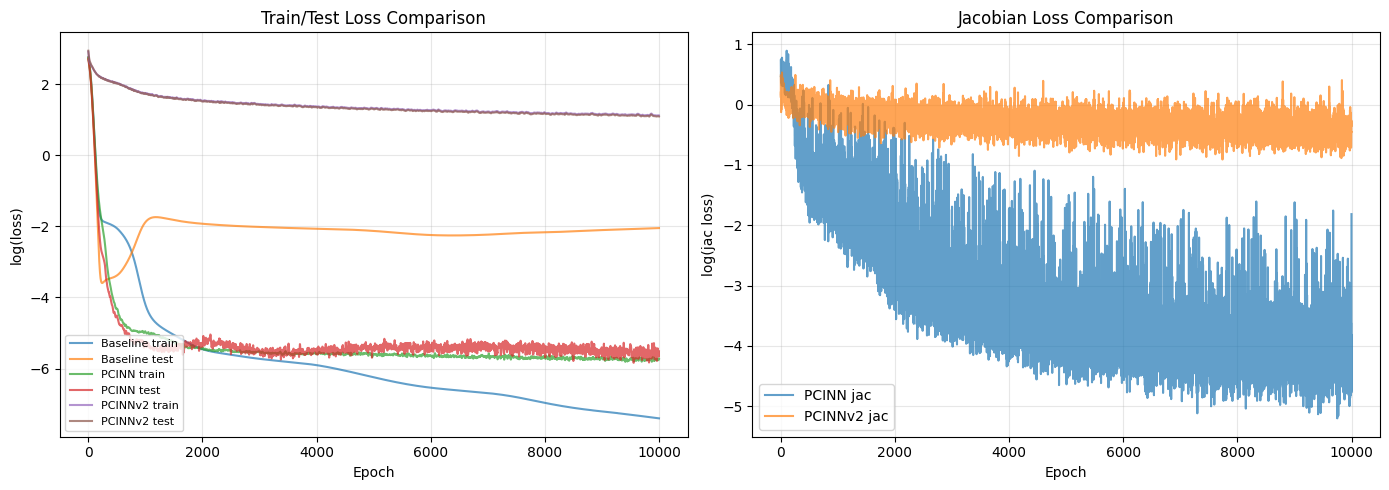


Final test losses:
  Baseline NN: 0.129292
  PCINN:       0.00403127
  PCINNv2:     2.99175


In [16]:
USE_FOURIER = False  # Set True to enable Fourier feature encoding

pcinnv2_model = PCINNv2(
    theory_model=Domain_NN,
    hidden=64,
    use_fourier=USE_FOURIER,
).to(DEVICE)

loss_function = nn.MSELoss()
# Only optimize delta network parameters (theory is frozen inside PCINNv2)
trainable_params = [p for p in pcinnv2_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=3e-4)

EPOCHS = 10_000
TOTAL_JAC_SAMPLES = 32

v2_train_losses: list[float] = []
v2_test_losses: list[float] = []
v2_jac_losses: list[float] = []

print(f"PCINNv2 trainable params: {sum(p.numel() for p in trainable_params):,}")
print(f"Fourier features: {USE_FOURIER}")

for epoch in range(EPOCHS):
    pcinnv2_model.train()
    optimizer.zero_grad(set_to_none=True)

    # Data loss in log-space (same as baseline PCINN)
    pred = pcinnv2_model(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)

    # --- Jacobian sampling ---
    Msample = M_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Ssample = 10 - Msample
    Isample = I_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    Tsample = T_sampler.sample((TOTAL_JAC_SAMPLES, 1))
    tsample = time_sampler.sample((TOTAL_JAC_SAMPLES, 1))

    sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), dim=1).to(DEVICE)
    sampl = (sampl - SCALERX_MIN) / SCALERX_DENOM
    sampl = sampl.float().detach().requires_grad_(True)

    # Jacobian matching in PHYSICAL space (Section 6.7 Option A)
    # Theory Jacobian (already in physical units)
    jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl).detach()
    # PCINNv2 Jacobian via forward_physical (also physical units)
    jac_sampl = vmap(jacrev(pcinnv2_model.forward_physical))(sampl)

    jacloss = loss_function(jac_sampl, jac_theory_sampl)

    loss = trainloss + jacloss
    loss.backward()
    optimizer.step()

    v2_train_losses.append(trainloss.item())
    v2_jac_losses.append(jacloss.item())

    pcinnv2_model.eval()
    with torch.inference_mode():
        test_pred = pcinnv2_model(Xtestsample)
        testloss = loss_function(test_pred, Ytestsample).item()
    v2_test_losses.append(testloss)

    if (epoch + 1) % 500 == 0:
        print(
            f"[PCINNv2] epoch={epoch+1}/{EPOCHS} "
            f"obj={v2_train_losses[-1]:.6g} jac={v2_jac_losses[-1]:.6g} test={v2_test_losses[-1]:.6g}"
        )

V2pred = pcinnv2_model(Xtestsample)

# --- Comparison plot: all three models ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: train + test loss
axes[0].plot(safe_log(train_losses), label="Baseline train", alpha=0.7)
axes[0].plot(safe_log(test_losses), label="Baseline test", alpha=0.7)
axes[0].plot(safe_log(pcinn_train_losses), label="PCINN train", alpha=0.7)
axes[0].plot(safe_log(pcinn_test_losses), label="PCINN test", alpha=0.7)
axes[0].plot(safe_log(v2_train_losses), label="PCINNv2 train", alpha=0.7)
axes[0].plot(safe_log(v2_test_losses), label="PCINNv2 test", alpha=0.7)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("log(loss)")
axes[0].set_title("Train/Test Loss Comparison")
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=8)

# Right: Jacobian losses
axes[1].plot(safe_log(jac_losses), label="PCINN jac", alpha=0.7)
axes[1].plot(safe_log(v2_jac_losses), label="PCINNv2 jac", alpha=0.7)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("log(jac loss)")
axes[1].set_title("Jacobian Loss Comparison")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nFinal test losses:")
print(f"  Baseline NN: {test_losses[-1]:.6g}")
print(f"  PCINN:       {pcinn_test_losses[-1]:.6g}")
print(f"  PCINNv2:     {v2_test_losses[-1]:.6g}")

## Results Summary

Compare the train/test loss curves from both models above. The PCINN should show lower test loss than the baseline NN, demonstrating that Jacobian regularization from the theory model improves generalization. To reproduce the full leave-one-experiment-out cross-validation results from paper Table 3, re-run this notebook with `TestReaction` set to each integer from 1 to 8 and aggregate the per-reaction test errors.